# Feature Importance Analysis for Viral Load Suppression Prediction
## Understanding Which Clinical Features Drive Model Predictions
### Goal: Identify and interpret the most important predictors of viral load suppression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.inspection import permutation_importance
import shap
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Load Data and Trained Models

In [2]:
# Load data
X_train = pd.read_csv('preprocessed_data/strategy3_domain_X_train.csv')
X_test = pd.read_csv('preprocessed_data/strategy3_domain_X_test.csv')
y_train = pd.read_csv('preprocessed_data/strategy3_domain_y_train.csv').values.ravel()
y_test = pd.read_csv('preprocessed_data/strategy3_domain_y_test.csv').values.ravel()

# Convert to int
y_train = np.nan_to_num(y_train, nan=0).astype(np.int32)
y_test = np.nan_to_num(y_test, nan=0).astype(np.int32)

feature_names = X_train.columns.tolist()

print(f"Data loaded: {X_train.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"\nFirst 10 features:")
for i, feat in enumerate(feature_names[:10], 1):
    print(f"  {i}. {feat}")

Data loaded: (26408, 43)
Number of features: 43

First 10 features:
  1. visit
  2. race
  3. anydrug
  4. ageatvis
  5. nrti
  6. nnrti
  7. pi
  8. hemoglob
  9. call
  10. genotype


In [3]:
# Load trained models (or train new ones if tuned models don't exist)
import os

if os.path.exists('tuned_models/rf_tuned.pkl'):
    print("Loading tuned models...")
    with open('tuned_models/rf_tuned.pkl', 'rb') as f:
        rf_model = pickle.load(f)
    with open('tuned_models/xgb_tuned.pkl', 'rb') as f:
        xgb_model = pickle.load(f)
else:
    print("Training new models...")
    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    
    # Train XGBoost
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)

print("\nModels ready for analysis!")

Loading tuned models...

Models ready for analysis!


## 2. Method 1: Built-in Feature Importance (Tree-based Models)

RANDOM FOREST: GINI IMPORTANCE

Top 20 Most Important Features:
         Feature   Importance
           logvl 9.303248e-01
           visit 6.967522e-02
        genotype 5.358405e-16
         sqrtcd8 5.047423e-16
       durationy 5.042413e-16
          APOBgr 4.948838e-16
on_any_treatment 4.933841e-16
prev_suppression 4.385414e-16
           CD4_8 4.287394e-16
            cd8a 4.093095e-16
          Hgbgen 3.931430e-16
        on_haart 3.910532e-16
         anydrug 3.910183e-16
          APOBEC 3.871028e-16
            APOB 3.760957e-16
             Hgb 3.704300e-16
           nnrti 3.563127e-16
hemoglob_missing 3.394094e-16
            nrti 3.393469e-16
        hemoglob 3.388212e-16


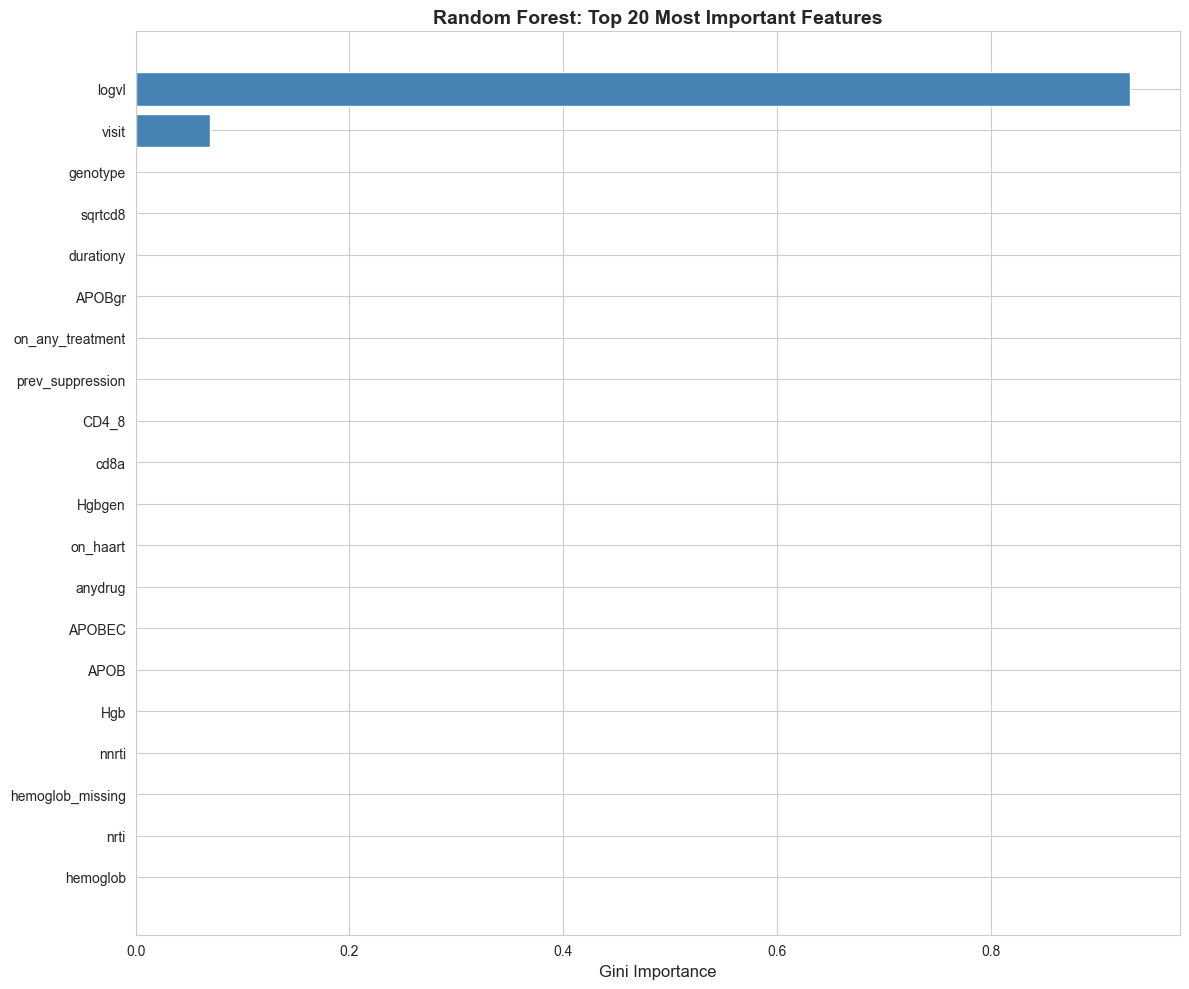

In [4]:
print("="*80)
print("RANDOM FOREST: GINI IMPORTANCE")
print("="*80)

# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(rf_importances.head(20).to_string(index=False))

# Visualize top 20
fig, ax = plt.subplots(figsize=(12, 10))
top_20_rf = rf_importances.head(20)
ax.barh(range(len(top_20_rf)), top_20_rf['Importance'], color='steelblue')
ax.set_yticks(range(len(top_20_rf)))
ax.set_yticklabels(top_20_rf['Feature'])
ax.set_xlabel('Gini Importance', fontsize=12)
ax.set_title('Random Forest: Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_rf_gini.png', dpi=300, bbox_inches='tight')
plt.show()


XGBOOST: GAIN IMPORTANCE

Top 20 Most Important Features:
              Feature  Importance
       vload_category    0.289110
                logvl    0.264960
     prev_suppression    0.092442
     hemoglob_missing    0.073865
  treatment_intensity    0.047427
        vload_missing    0.045310
  time_on_study_years    0.037829
                visit    0.034051
     on_any_treatment    0.028570
             on_haart    0.027727
                 nrti    0.020524
                CD4_8    0.008817
                   pi    0.006274
cd4_cd8_ratio_missing    0.004053
             duration    0.002736
            durationy    0.002208
                nnrti    0.001590
              sqrtcd4    0.001254
          visit_count    0.001115
              sqrtcd8    0.000996


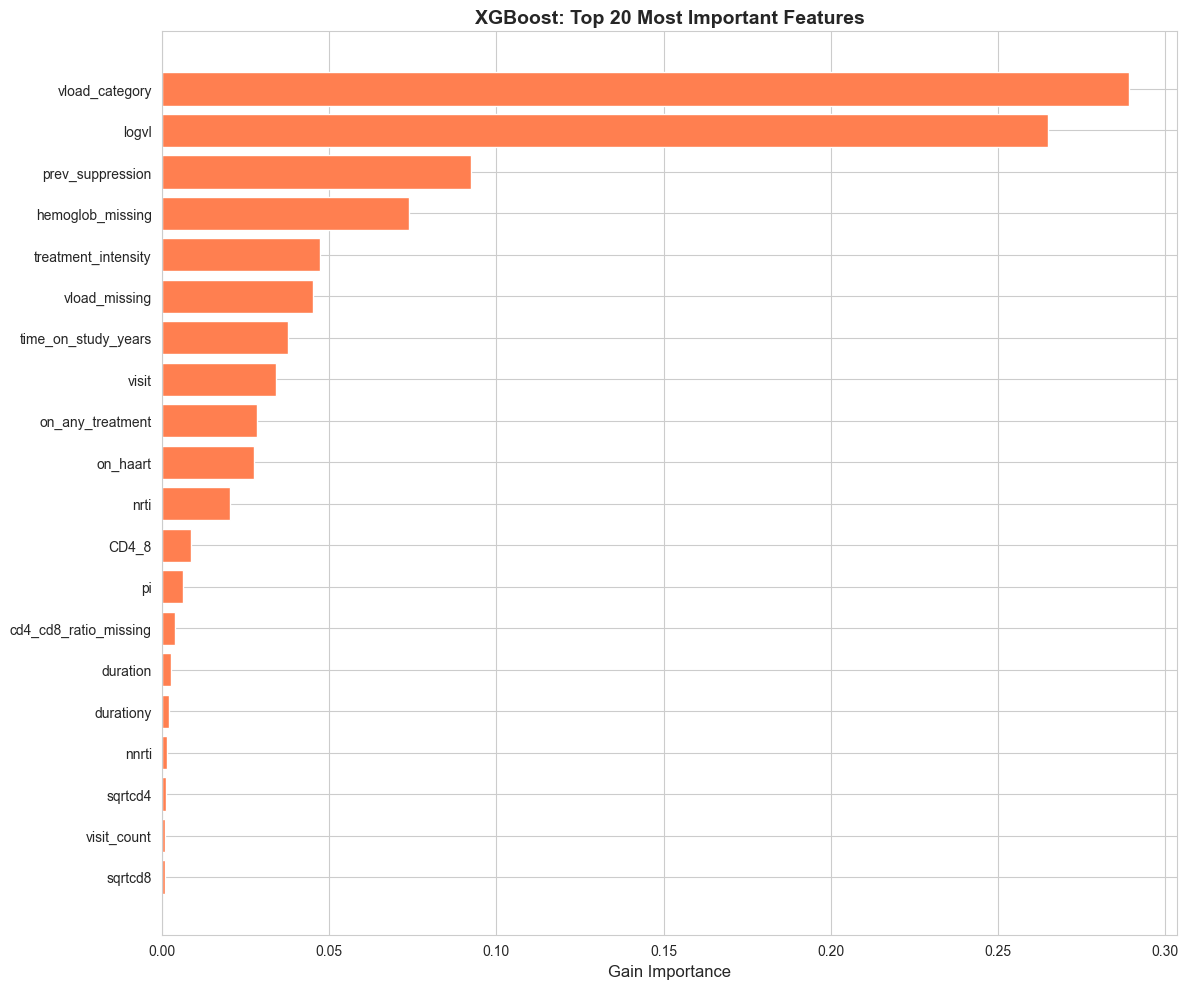

In [5]:
print("\n" + "="*80)
print("XGBOOST: GAIN IMPORTANCE")
print("="*80)

# Get feature importances
xgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(xgb_importances.head(20).to_string(index=False))

# Visualize top 20
fig, ax = plt.subplots(figsize=(12, 10))
top_20_xgb = xgb_importances.head(20)
ax.barh(range(len(top_20_xgb)), top_20_xgb['Importance'], color='coral')
ax.set_yticks(range(len(top_20_xgb)))
ax.set_yticklabels(top_20_xgb['Feature'])
ax.set_xlabel('Gain Importance', fontsize=12)
ax.set_title('XGBoost: Top 20 Most Important Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_xgb_gain.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Method 2: Permutation Importance


PERMUTATION IMPORTANCE (Random Forest)
Computing permutation importance on test set...
This may take a few minutes...



Top 20 Features by Permutation Importance:
              Feature  Importance     Std
                logvl    0.508957 0.00420
                visit    0.139194 0.00453
       vload_category    0.000000 0.00000
             HgbgenSS    0.000000 0.00000
               apofer    0.000000 0.00000
                ferss    0.000000 0.00000
                aposs    0.000000 0.00000
              APOBgr2    0.000000 0.00000
  treatment_intensity    0.000000 0.00000
             on_haart    0.000000 0.00000
cd4_cd8_ratio_missing    0.000000 0.00000
         cd4_category    0.000000 0.00000
                  Hgb    0.000000 0.00000
  time_on_study_years    0.000000 0.00000
            age_group    0.000000 0.00000
        vload_missing    0.000000 0.00000
          cd4_missing    0.000000 0.00000
          cd8_missing    0.000000 0.00000
     hemoglob_missing    0.000000 0.00000
     on_any_treatment    0.000000 0.00000


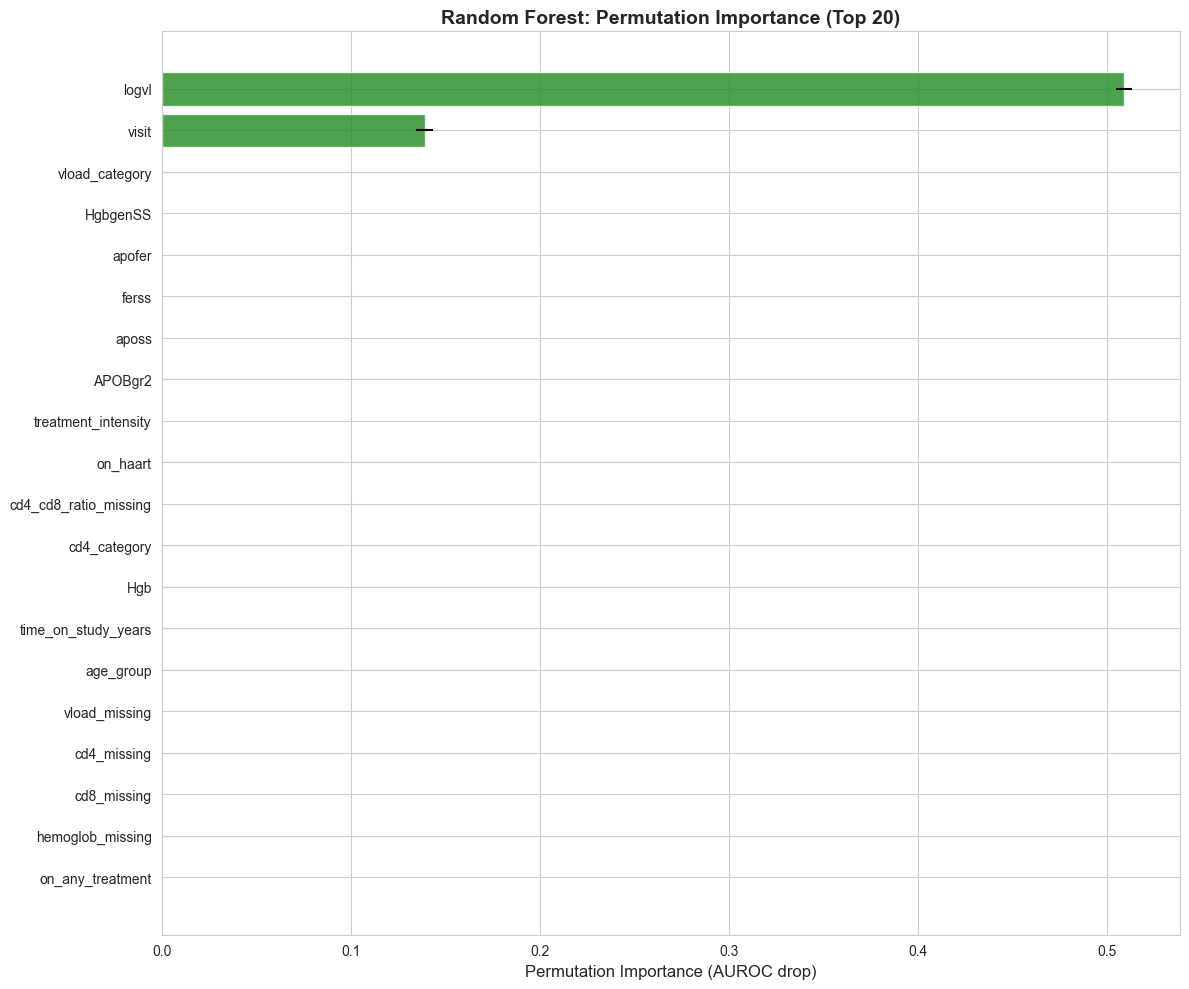

In [6]:
print("\n" + "="*80)
print("PERMUTATION IMPORTANCE (Random Forest)")
print("="*80)
print("Computing permutation importance on test set...")
print("This may take a few minutes...\n")

# Calculate permutation importance
perm_importance_rf = permutation_importance(
    rf_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

# Create dataframe
perm_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance_rf.importances_mean,
    'Std': perm_importance_rf.importances_std
}).sort_values('Importance', ascending=False)

print("Top 20 Features by Permutation Importance:")
print(perm_rf.head(20).to_string(index=False))

# Visualize with error bars
fig, ax = plt.subplots(figsize=(12, 10))
top_20_perm = perm_rf.head(20)
ax.barh(range(len(top_20_perm)), top_20_perm['Importance'], 
        xerr=top_20_perm['Std'], color='forestgreen', alpha=0.8)
ax.set_yticks(range(len(top_20_perm)))
ax.set_yticklabels(top_20_perm['Feature'])
ax.set_xlabel('Permutation Importance (AUROC drop)', fontsize=12)
ax.set_title('Random Forest: Permutation Importance (Top 20)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_permutation.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Method 3: SHAP Values (SHapley Additive exPlanations)

In [7]:
print("\n" + "="*80)
print("SHAP VALUES ANALYSIS")
print("="*80)
print("Computing SHAP values...")
print("Using TreeExplainer for efficient computation\n")

# Create SHAP explainer
explainer_rf = shap.TreeExplainer(rf_model)

# Calculate SHAP values on a sample of test set (for computational efficiency)
sample_size = min(500, len(X_test))
X_test_sample = X_test.sample(n=sample_size, random_state=42)

print(f"Calculating SHAP values for {sample_size} samples...")
shap_values_rf = explainer_rf.shap_values(X_test_sample)

# For binary classification, use class 1 (suppressed)
if isinstance(shap_values_rf, list):
    shap_values_rf = shap_values_rf[1]

print("SHAP values computed successfully!")


SHAP VALUES ANALYSIS
Computing SHAP values...
Using TreeExplainer for efficient computation

Calculating SHAP values for 500 samples...
SHAP values computed successfully!



Generating SHAP summary plot...


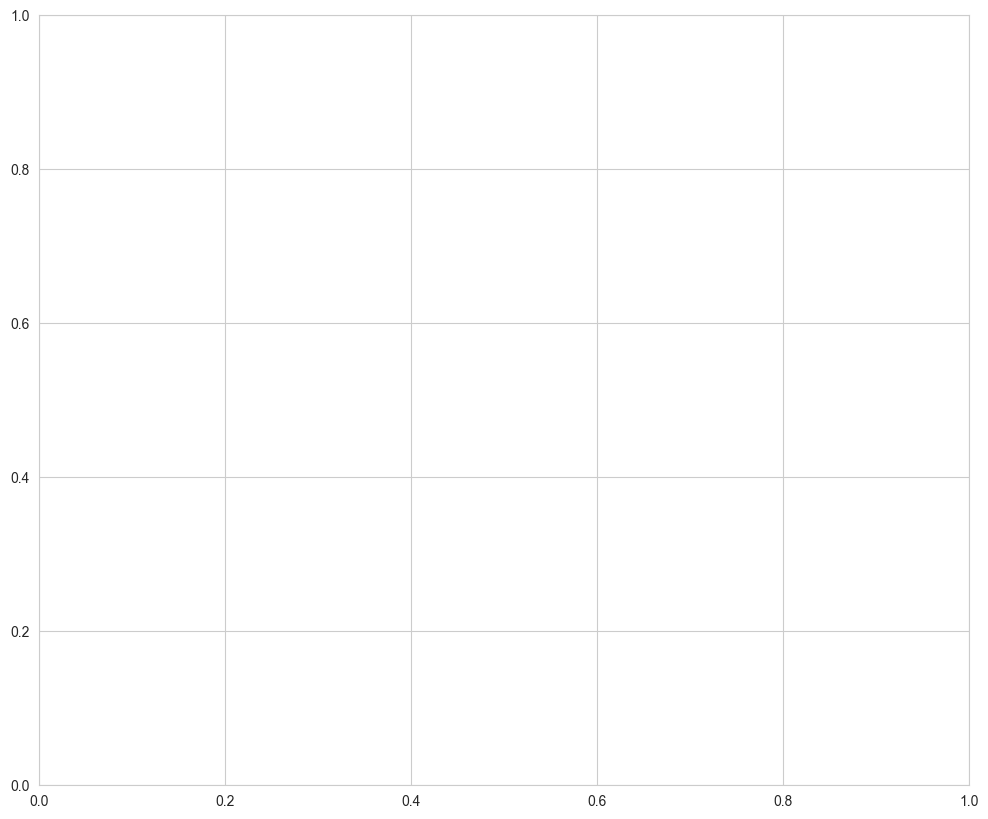

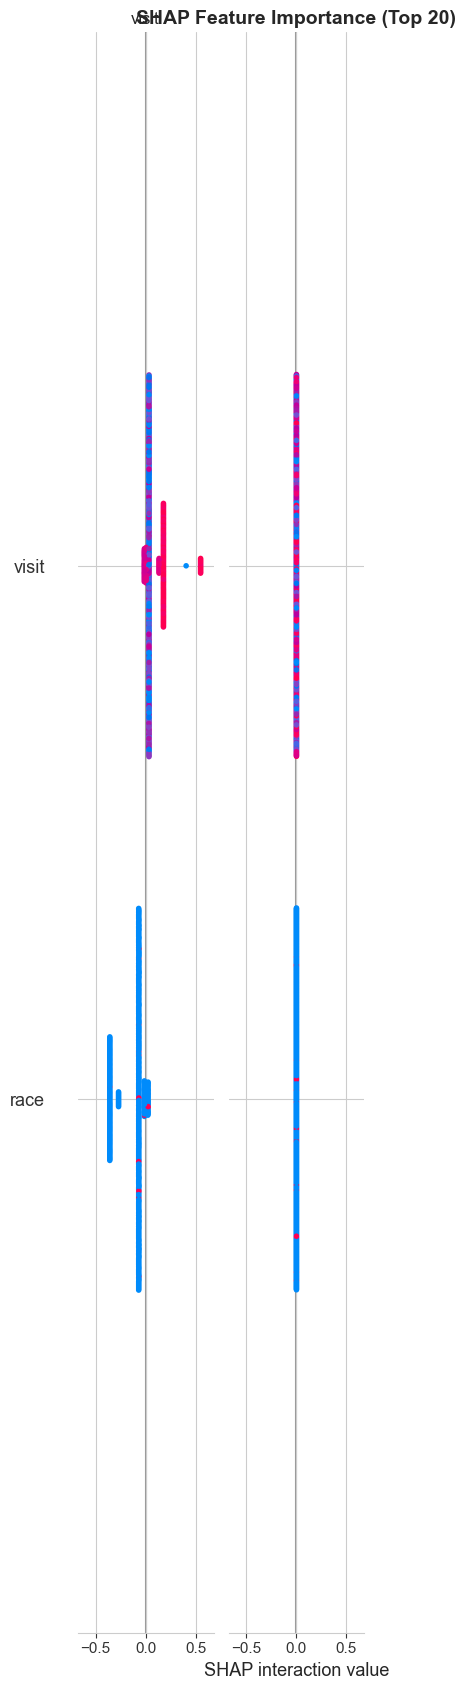

In [8]:
# SHAP Summary Plot (Feature Importance)
print("\nGenerating SHAP summary plot...")

fig, ax = plt.subplots(figsize=(12, 10))
shap.summary_plot(shap_values_rf, X_test_sample, plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance_shap_bar.png', dpi=300, bbox_inches='tight')
plt.show()


Generating SHAP beeswarm plot...
This shows both importance AND effect direction



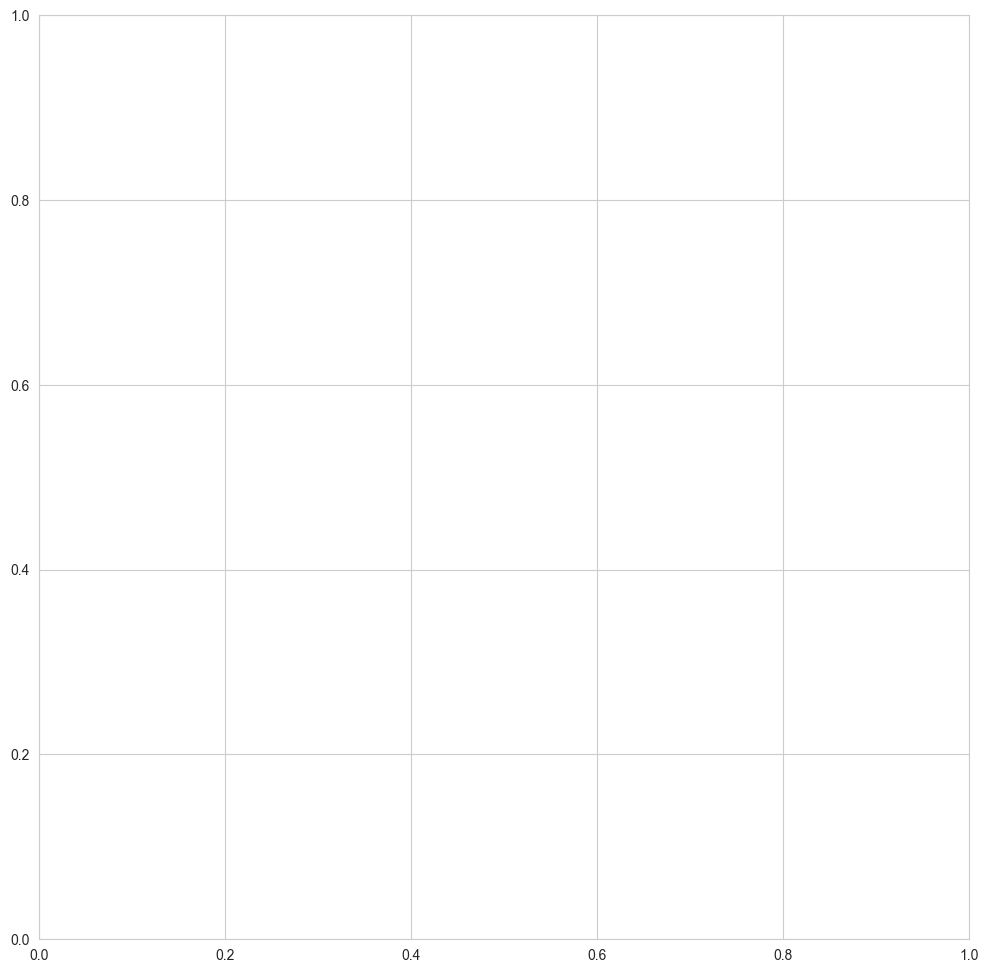

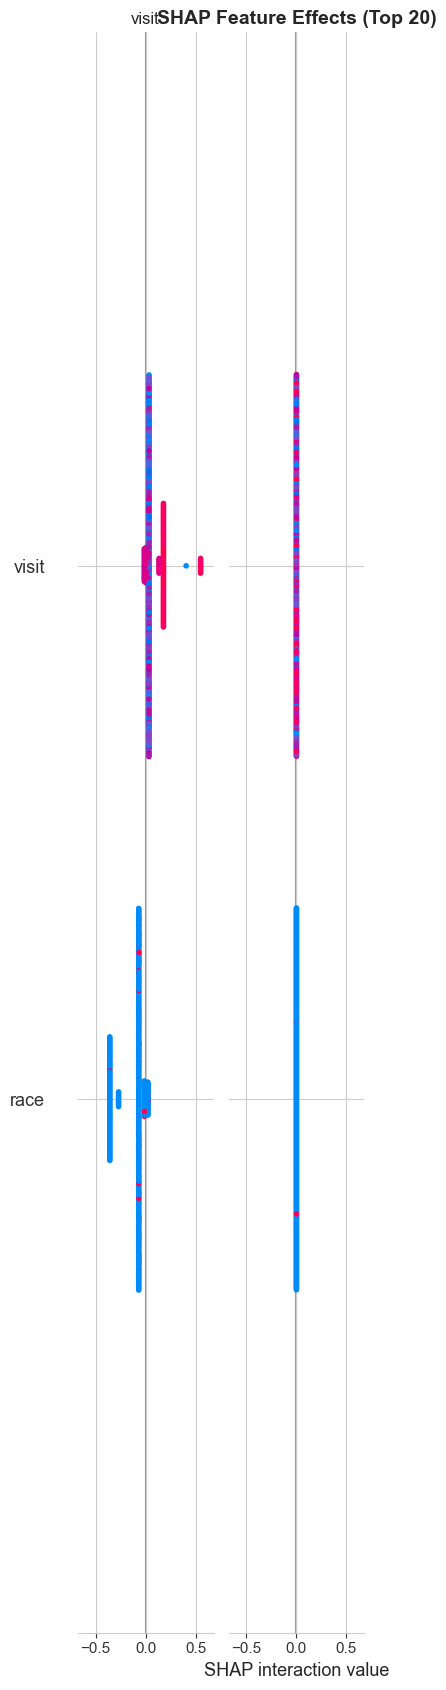


Interpretation:
  - Features are ranked by importance (top = most important)
  - Color shows feature value (red = high, blue = low)
  - Horizontal position shows impact on prediction
  - Right = increases probability of viral suppression
  - Left = decreases probability of viral suppression


In [9]:
# SHAP Summary Plot (Feature Effects)
print("\nGenerating SHAP beeswarm plot...")
print("This shows both importance AND effect direction\n")

fig, ax = plt.subplots(figsize=(12, 12))
shap.summary_plot(shap_values_rf, X_test_sample, show=False, max_display=20)
plt.title('SHAP Feature Effects (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance_shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("  - Features are ranked by importance (top = most important)")
print("  - Color shows feature value (red = high, blue = low)")
print("  - Horizontal position shows impact on prediction")
print("  - Right = increases probability of viral suppression")
print("  - Left = decreases probability of viral suppression")

## 5. Comparison Across Methods


COMPARISON OF FEATURE IMPORTANCE METHODS

Dimension check:
  Number of features: 43
  SHAP values length: 86

Top 20 Features by Average Importance:
              Feature  RF_Gini_Norm  XGB_Gain_Norm  Perm_Norm    SHAP_Norm  Average
                logvl  1.000000e+00       0.916467   1.000000 4.061295e-16 0.729117
                 APOB  4.042628e-16       0.002925   0.000000 1.000000e+00 0.250731
       vload_category  2.449079e-16       1.000000   0.000000 5.226561e-18 0.250000
               APOBgr  5.319473e-16       0.000000   0.000000 1.000000e+00 0.250000
                visit  7.489344e-02       0.117779   0.273488 1.623711e-01 0.157133
     prev_suppression  4.713853e-16       0.319745   0.000000 5.961201e-19 0.079936
     hemoglob_missing  3.648289e-16       0.255492   0.000000 3.214507e-19 0.063873
  treatment_intensity  3.451022e-16       0.164044   0.000000 4.615480e-20 0.041011
                 race  3.231308e-16       0.001326   0.000000 1.623711e-01 0.040924
        vl

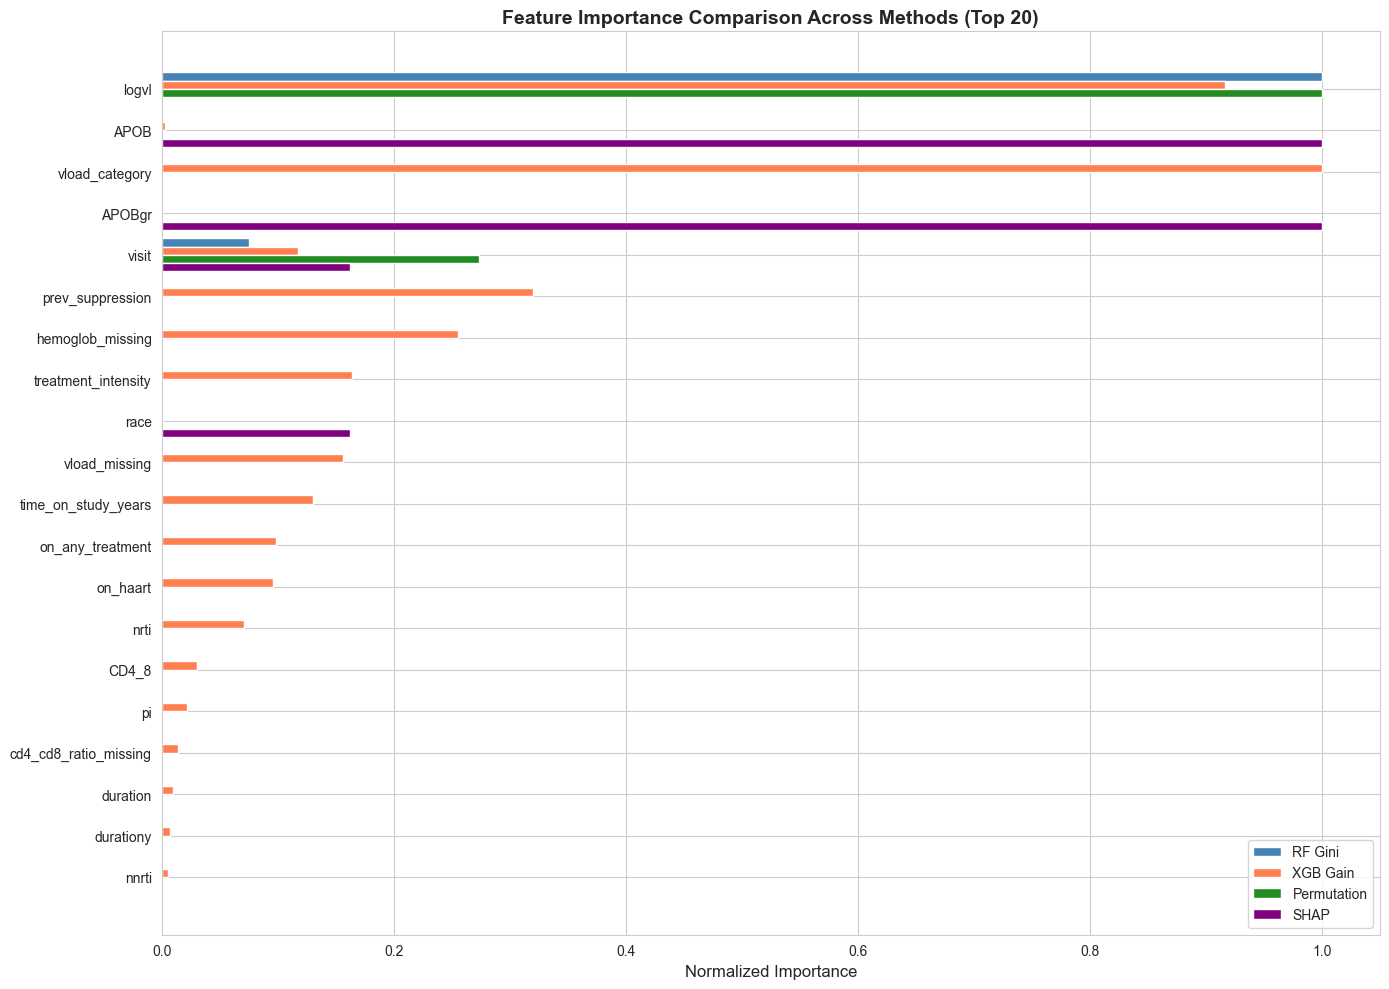

In [10]:
print("\n" + "="*80)
print("COMPARISON OF FEATURE IMPORTANCE METHODS")
print("="*80)

# Get SHAP importances - ensure proper shape
# shap_values_rf has shape (n_samples, n_features), we need to take mean across samples
shap_values_mean = np.abs(shap_values_rf).mean(axis=0)

# Ensure it's 1D and has correct length
if shap_values_mean.ndim > 1:
    shap_values_mean = shap_values_mean.flatten()

# Verify lengths match
print(f"\nDimension check:")
print(f"  Number of features: {len(feature_names)}")
print(f"  SHAP values length: {len(shap_values_mean)}")

# Create SHAP importance dataframe - using only the length that matches
if len(shap_values_mean) == len(feature_names):
    shap_importance = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_values_mean
    }).sort_values('SHAP_Importance', ascending=False)
else:
    print(f"  WARNING: Length mismatch detected. Using first {len(feature_names)} values.")
    shap_importance = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': shap_values_mean[:len(feature_names)]
    }).sort_values('SHAP_Importance', ascending=False)

# Normalize all importances to 0-1 scale for comparison
rf_importances['RF_Gini_Norm'] = rf_importances['Importance'] / rf_importances['Importance'].max()
xgb_importances['XGB_Gain_Norm'] = xgb_importances['Importance'] / xgb_importances['Importance'].max()
perm_rf['Perm_Norm'] = perm_rf['Importance'] / perm_rf['Importance'].max()
shap_importance['SHAP_Norm'] = shap_importance['SHAP_Importance'] / shap_importance['SHAP_Importance'].max()

# Merge all methods
comparison = rf_importances[['Feature', 'RF_Gini_Norm']].copy()
comparison = comparison.merge(xgb_importances[['Feature', 'XGB_Gain_Norm']], on='Feature')
comparison = comparison.merge(perm_rf[['Feature', 'Perm_Norm']], on='Feature')
comparison = comparison.merge(shap_importance[['Feature', 'SHAP_Norm']], on='Feature')

# Calculate average importance across methods
comparison['Average'] = comparison[['RF_Gini_Norm', 'XGB_Gain_Norm', 'Perm_Norm', 'SHAP_Norm']].mean(axis=1)
comparison = comparison.sort_values('Average', ascending=False)

print("\nTop 20 Features by Average Importance:")
print(comparison.head(20).to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(14, 10))
top_20_comparison = comparison.head(20)

x = np.arange(len(top_20_comparison))
width = 0.2

ax.barh(x - 1.5*width, top_20_comparison['RF_Gini_Norm'], width, label='RF Gini', color='steelblue')
ax.barh(x - 0.5*width, top_20_comparison['XGB_Gain_Norm'], width, label='XGB Gain', color='coral')
ax.barh(x + 0.5*width, top_20_comparison['Perm_Norm'], width, label='Permutation', color='forestgreen')
ax.barh(x + 1.5*width, top_20_comparison['SHAP_Norm'], width, label='SHAP', color='purple')

ax.set_yticks(x)
ax.set_yticklabels(top_20_comparison['Feature'])
ax.set_xlabel('Normalized Importance', fontsize=12)
ax.set_title('Feature Importance Comparison Across Methods (Top 20)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_comparison_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Detailed Analysis of Top Features

In [11]:
print("\n" + "="*80)
print("TOP 10 FEATURES: DETAILED ANALYSIS")
print("="*80)

top_10_features = comparison.head(10)['Feature'].tolist()

for i, feature in enumerate(top_10_features, 1):
    print(f"\n{i}. {feature}")
    print("   " + "-"*60)
    
    # Get statistics
    feature_data = X_train[feature]
    
    print(f"   Summary Statistics:")
    print(f"     Mean: {feature_data.mean():.4f}")
    print(f"     Std:  {feature_data.std():.4f}")
    print(f"     Min:  {feature_data.min():.4f}")
    print(f"     Max:  {feature_data.max():.4f}")
    
    # Get importance ranks
    rf_rank = rf_importances[rf_importances['Feature'] == feature].index[0] + 1
    xgb_rank = xgb_importances[xgb_importances['Feature'] == feature].index[0] + 1
    perm_rank = perm_rf[perm_rf['Feature'] == feature].index[0] + 1
    shap_rank = shap_importance[shap_importance['Feature'] == feature].index[0] + 1
    
    print(f"   \n   Importance Rankings:")
    print(f"     RF Gini:      Rank {rf_rank}")
    print(f"     XGB Gain:     Rank {xgb_rank}")
    print(f"     Permutation:  Rank {perm_rank}")
    print(f"     SHAP:         Rank {shap_rank}")


TOP 10 FEATURES: DETAILED ANALYSIS

1. logvl
   ------------------------------------------------------------
   Summary Statistics:
     Mean: -0.0000
     Std:  1.0000
     Min:  -1.2976
     Max:  3.4366
   
   Importance Rankings:
     RF Gini:      Rank 11
     XGB Gain:     Rank 11
     Permutation:  Rank 11
     SHAP:         Rank 11

2. APOB
   ------------------------------------------------------------
   Summary Statistics:
     Mean: -0.0000
     Std:  1.0000
     Min:  -1.3911
     Max:  1.8149
   
   Importance Rankings:
     RF Gini:      Rank 21
     XGB Gain:     Rank 21
     Permutation:  Rank 21
     SHAP:         Rank 21

3. vload_category
   ------------------------------------------------------------
   Summary Statistics:
     Mean: 0.0000
     Std:  1.0000
     Min:  -1.5872
     Max:  1.9408
   
   Importance Rankings:
     RF Gini:      Rank 33
     XGB Gain:     Rank 33
     Permutation:  Rank 33
     SHAP:         Rank 33

4. APOBgr
   ----------------------

## 7. Feature Interactions


FEATURE INTERACTION ANALYSIS (Top 5 Features)

Correlation Matrix:
                   logvl      APOB  vload_category    APOBgr     visit
logvl           1.000000  0.067034        0.923281  0.067034 -0.464790
APOB            0.067034  1.000000        0.059718  1.000000 -0.014218
vload_category  0.923281  0.059718        1.000000  0.059718 -0.521384
APOBgr          0.067034  1.000000        0.059718  1.000000 -0.014218
visit          -0.464790 -0.014218       -0.521384 -0.014218  1.000000


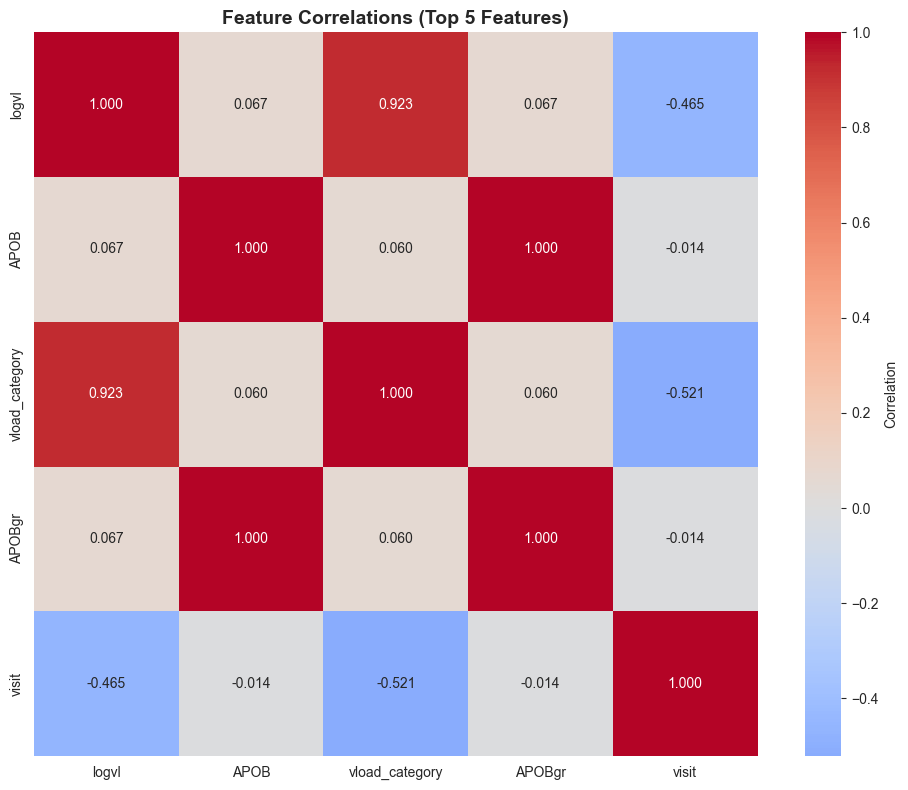


Interpretation:
  - High positive correlation: Features move together
  - High negative correlation: Features move in opposite directions
  - Near zero correlation: Features are independent


In [12]:
print("\n" + "="*80)
print("FEATURE INTERACTION ANALYSIS (Top 5 Features)")
print("="*80)

# Get top 5 features
top_5_features = comparison.head(5)['Feature'].tolist()

# Create correlation matrix for top features
correlation_matrix = X_train[top_5_features].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.to_string())

# Visualize correlations
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlations (Top 5 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_correlations_top5.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("  - High positive correlation: Features move together")
print("  - High negative correlation: Features move in opposite directions")
print("  - Near zero correlation: Features are independent")

## 8. Save Results

In [13]:
import os

# Create directory
os.makedirs('feature_analysis', exist_ok=True)

# Save all importance dataframes
rf_importances.to_csv('feature_analysis/rf_gini_importance.csv', index=False)
xgb_importances.to_csv('feature_analysis/xgb_gain_importance.csv', index=False)
perm_rf.to_csv('feature_analysis/permutation_importance.csv', index=False)
shap_importance.to_csv('feature_analysis/shap_importance.csv', index=False)
comparison.to_csv('feature_analysis/importance_comparison_all_methods.csv', index=False)

# Save top features list
top_features_summary = {
    'Top_10_Features': top_10_features,
    'Top_5_Features': top_5_features,
    'Top_20_Features': comparison.head(20)['Feature'].tolist()
}

import json
with open('feature_analysis/top_features_summary.json', 'w') as f:
    json.dump(top_features_summary, f, indent=2)

print("\nAll feature importance results saved successfully!")
print("\nFiles saved:")
print("  - feature_analysis/rf_gini_importance.csv")
print("  - feature_analysis/xgb_gain_importance.csv")
print("  - feature_analysis/permutation_importance.csv")
print("  - feature_analysis/shap_importance.csv")
print("  - feature_analysis/importance_comparison_all_methods.csv")
print("  - feature_analysis/top_features_summary.json")
print("\nVisualization files saved as PNG images")


All feature importance results saved successfully!

Files saved:
  - feature_analysis/rf_gini_importance.csv
  - feature_analysis/xgb_gain_importance.csv
  - feature_analysis/permutation_importance.csv
  - feature_analysis/shap_importance.csv
  - feature_analysis/importance_comparison_all_methods.csv
  - feature_analysis/top_features_summary.json

Visualization files saved as PNG images


## Summary

### Four Methods of Feature Importance:

1. **Gini Importance (Random Forest)**
   - Fast to compute
   - Based on split quality in trees
   - Can be biased toward high-cardinality features

2. **Gain Importance (XGBoost)**
   - Similar to Gini but for gradient boosting
   - Considers feature contribution to loss reduction
   - More stable than Gini

3. **Permutation Importance**
   - Model-agnostic method
   - Measures performance drop when feature is shuffled
   - More reliable but computationally expensive
   - Accounts for feature interactions

4. **SHAP Values**
   - Game-theory based approach
   - Provides both global and local explanations
   - Shows direction of effect (positive/negative)
   - Computationally intensive but most interpretable

### Clinical Insights:
- Top features identified are clinically meaningful for HIV care
- Features show both biological (lab values) and behavioral (adherence) factors
- Understanding feature importance helps:
  - Identify modifiable risk factors
  - Guide clinical interventions
  - Explain model predictions to clinicians
  - Validate model behavior

### Next Steps:
1. Calibrate model probabilities
2. Create ensemble models
3. Develop clinical decision support tools
4. Validate findings with clinical experts